# **Image Dataset**

In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

## Importação de pacotes e leitura dos dados

In [2]:
import numpy as np
import pandas as pd
import os
import imageio
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import make_scorer, balanced_accuracy_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from utils import get_train_val_set_data
sns.set()


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

### Lendo as imagens em formato RGB

Dimensões para corte das imagens para retirar bordas brancas

In [13]:
left = 50
top = 30
right = 395
bottom = 260

Path para processamento dos arquivos de imagem para numpy arrays

In [12]:
# 
my_path = '../dataset/Data/'

Processando os dados de imagem para numpy arrays

In [14]:
file_values = []
file_name = []
file_genre = []

folder_path = my_path + 'images_rgb/'
genre_folders = os.listdir(folder_path)

for genre_folder in genre_folders:
  
  files = os.listdir(folder_path + genre_folder)
  print(genre_folder, len(files))
  
  for image in files:

    img = Image.open(folder_path + genre_folder+ "/" +image)
    crop_img = img.crop((left, top, right, bottom)) #Reduzindo o tamanho da imagem cortando as bordas brancas
    image_array = np.array(crop_img)
    file_values.append(image_array)
    
    file_name.append(image)
    file_genre.append(genre_folder)

blues 100
classical 100
country 100
disco 100
hiphop 100
jazz 99
metal 100
pop 100
reggae 100
rock 100


In [7]:
df_dict = {
    'filename': file_name,
    'file_values': file_values,
    'label': file_genre,
}

df = pd.DataFrame(df_dict)

## Dividindo em treino, validação e teste

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_set_data(df)

-- Treino --
X (shape):  (699, 2)
y:  699
-- Validação --
X (shape):  (150, 2)
y:  150
-- Teste --
X (shape):  (150, 2)
y:  150


## Data Prep

### Features

In [9]:
len(X_train.file_values[0]), len(X_train.file_values[0][0]), len(X_train.file_values[0][0][0])

(230, 345, 3)

Modificando as dimensões dos dados de imagem para um formato para serem usados no modelo.

In [10]:
X_train = np.concatenate(X_train.file_values.values).reshape(X_train.shape[0], 230, 345, 3)
X_val = np.concatenate(X_val.file_values.values).reshape(X_val.shape[0], 230, 345, 3)
X_test = np.concatenate(X_test.file_values.values).reshape(X_test.shape[0], 230, 345, 3)

Apresentando uma imagem de exemplo

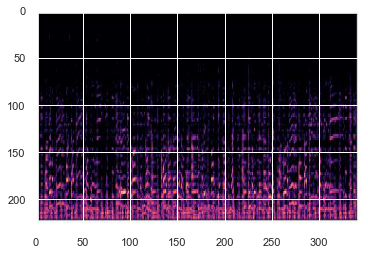

In [11]:
plt.imshow(X_train[0])

### Variável target

Utilizando Label Encoding para transformar os generos musicais em números de 0 a 9

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(y_train)

Y_train = le.transform(y_train)
Y_val = le.transform(y_val)
Y_Test = le.transform(y_test)

print('Exemplo antes:', Y_train[0])

Exemplo antes: 4


Transformando as saídas no formato de One Hot Encoding 

In [ ]:
n_classes = 10

Y_train = tf.keras.utils.to_categorical(Y_train, n_classes)
Y_val = tf.keras.utils.to_categorical(Y_val, n_classes)
Y_test = tf.keras.utils.to_categorical(Y_Test, n_classes)

print('Exemplo depois:', Y_train[0])

Exemplo depois: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## Modelagens

### Funções auxiliares

Função que faz aumentação de dados dando zoom nas imagens

In [ ]:
def generate_batches(image_preprocessing):
  
  datagen = ImageDataGenerator(
      zoom_range=[0.9, 1.5],
      preprocessing_function= image_preprocessing
      )
  
  train_batches = datagen.flow(X_train, Y_train, shuffle=True, batch_size=70)
  val_batches = datagen.flow(X_val, Y_val, shuffle=False, batch_size=50)

  return train_batches, val_batches

Função que imprime acurácia balanceada e matriz de confusão de um modelo

In [ ]:
def plot_balanced_accuracy_heatmap(y, y_pred, labels = le.classes_):

  print(f'Acurácia balanceada:{balanced_accuracy_score(y, y_pred)}\n')

  plt.figure(figsize=(10,10))
  sns.heatmap(
      confusion_matrix(y, y_pred, normalize='true').round(2), 
      cmap='Blues', 
      annot=True,
      xticklabels=le.classes_, 
      yticklabels=le.classes_
  )
  plt.show()

Função que remove as últimas camadas de um modelo para fazer extração de features

In [ ]:
def feature_extrator(model, last_layers):

  feats_model = tf.keras.Sequential()
  
  for layer in model.layers[:last_layers]: 
    feats_model.add(layer)

  feats_model.summary()

  feats_x_train = feats_model.predict(X_train)
  feats_x_val = feats_model.predict(X_val)

  feats_y_train = np.argmax(Y_train, axis=1)
  feats_y_val = np.argmax(Y_val, axis=1)

  print('Train Shape: ', feats_x_train.shape)

  return feats_x_train, feats_y_train, feats_x_val, feats_y_val

Função que usa Grid Search em um SVM para retornar a predição do melhor modelo

In [ ]:
def train_predict_best_svm_model(x_train, y_train, x_val):

  C_range = np.logspace(-4, 4, 8)
  kernels = ['linear', 'rbf', 'sigmoid']
  param_grid = dict(C=C_range, kernel=kernels)
  print('param_grid:', param_grid)

  svc_model = SVC(random_state = 0)

  bas = make_scorer(balanced_accuracy_score, greater_is_better=True)

  grid = GridSearchCV(svc_model, param_grid, cv=5, scoring=bas,verbose=3)
  grid.fit(x_train, feats_y_train)

  print(grid.best_score_)
  print(grid.best_params_)
  print(grid.best_estimator_)

  best_svc = grid.best_estimator_
  y_pred_train = best_svc.predict(x_train)
  y_pred_val = best_svc.predict(x_val)

  return y_pred_train, y_pred_val

Função que usa Grid Search em uma Random Forest para retornar a predição do melhor modelo

In [ ]:
def train_predict_best_rf_model(x_train, y_train, x_val):

  estimators_range = [25, 50, 100, 200, 300]
  max_depths = [10, 25, 50, 75, 100]
  param_grid = dict(n_estimators=estimators_range, max_depth=max_depths)
  print('param_grid:', param_grid)

  rf_model = RandomForestClassifier(random_state = 0)

  bas = make_scorer(balanced_accuracy_score, greater_is_better=True)

  grid = GridSearchCV(rf_model, param_grid, cv=5, scoring=bas,verbose=3)
  grid.fit(feats_x_train, feats_y_train)

  print(grid.best_score_)
  print(grid.best_params_)
  print(grid.best_estimator_)

  best_rf = grid.best_estimator_
  y_pred_train = best_rf.predict(feats_x_train)
  y_pred_val = best_rf.predict(feats_x_val)

  return y_pred_train, y_pred_val

In [ ]:
input_shape = X_train[0].shape
input_shape

(230, 345, 3)

### ResNet50

#### Treinando a rede

In [ ]:
resnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    classes=1000,
    classifier_activation="softmax",
    input_shape = input_shape
)

resnet_model.trainable = True

resnet_model = tf.keras.Sequential([  
  resnet_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer= tf.keras.regularizers.l2(l=0.1))
])

resnet_model.build()
resnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 11, 2048)       23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
resnet_model.compile(
    loss='categorical_crossentropy', 
    optimizer=adam, 
    metrics=['accuracy']
)

In [ ]:
image_preprocessing = tf.keras.applications.resnet50.preprocess_input
train_batches, val_batches = generate_batches(image_preprocessing)

In [ ]:
resnet_model.fit( 
            train_batches,
            validation_data = val_batches, 
            epochs = 100,
            callbacks = [early]
        )

Epoch 1/100
10/10 [==============================] - 23s 2s/step - loss: 4.3535 - accuracy: 0.2089 - val_loss: 4.4288 - val_accuracy: 0.2200
Epoch 2/100
10/10 [==============================] - 16s 2s/step - loss: 3.5686 - accuracy: 0.4478 - val_loss: 4.2226 - val_accuracy: 0.2933
Epoch 3/100
10/10 [==============================] - 15s 2s/step - loss: 3.1998 - accuracy: 0.5708 - val_loss: 4.6290 - val_accuracy: 0.2733
Epoch 4/100
10/10 [==============================] - 15s 2s/step - loss: 2.8854 - accuracy: 0.6681 - val_loss: 4.9505 - val_accuracy: 0.2867
Epoch 5/100
10/10 [==============================] - 15s 2s/step - loss: 2.6234 - accuracy: 0.7396 - val_loss: 5.1565 - val_accuracy: 0.2600
Epoch 6/100
10/10 [==============================] - 16s 2s/step - loss: 2.4087 - accuracy: 0.7969 - val_loss: 5.1297 - val_accuracy: 0.3533
Epoch 7/100
10/10 [==============================] - 16s 2s/step - loss: 2.2789 - accuracy: 0.8283 - val_loss: 4.3586 - val_accuracy: 0.4000
Epoch 8/100
1

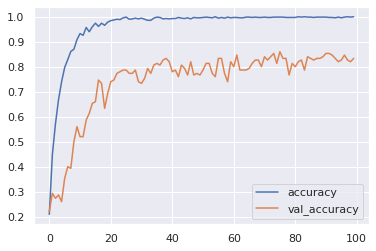

In [ ]:
history_df = pd.DataFrame(resnet_model.history.history)
history_df[['accuracy', 'val_accuracy']].plot()

Prevendo as classes com o modelo de ResNet50

In [ ]:
y_pred_train = np.argmax(resnet_model.predict(tf.keras.applications.resnet50.preprocess_input(X_train)), axis = 1)
y_pred_val = np.argmax(resnet_model.predict(tf.keras.applications.resnet50.preprocess_input(X_val)), axis = 1)

In [ ]:
feats_y_train = np.argmax(Y_train, axis=1)
feats_y_val = np.argmax(Y_val, axis=1)

Acurácia para os conjuntos de treino e validação

In [ ]:
accuracy_score(feats_y_train, y_pred_train)

0.9971387696709585

In [ ]:
accuracy_score(feats_y_val, y_pred_val)

0.8266666666666667

Acurácia balanceada:0.9971428571428571



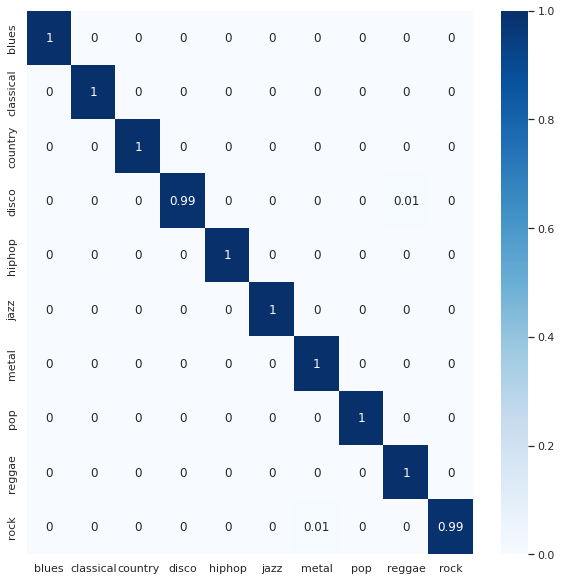

In [ ]:
plot_balanced_accuracy_heatmap(feats_y_train, y_pred_train)

Acurácia balanceada:0.8266666666666668



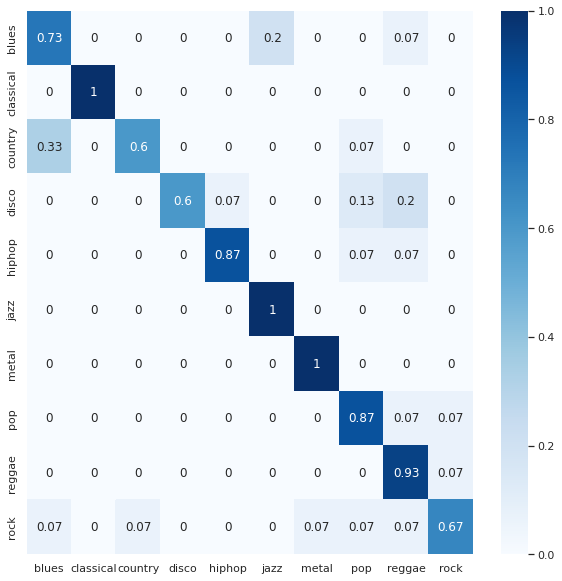

In [ ]:
plot_balanced_accuracy_heatmap(feats_y_val, y_pred_val)

#### Extraindo as features

In [ ]:
feats_x_train, feats_y_train, feats_x_val, feats_y_val = feature_extrator(resnet_model, -2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 11, 2048)       23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________
Train Shape:  (699, 2048)


#### SVM com Grid Search

In [ ]:
scaler = StandardScaler()

scaler.fit(feats_x_train)

feats_x_train = scaler.transform(feats_x_train)
feats_x_val = scaler.transform(feats_x_val)

In [ ]:
np.max(feats_x_train)

13.203664

In [ ]:
y_pred_train, y_pred_val = train_predict_best_svm_model(feats_x_train, feats_y_train, feats_x_val)

param_grid: {'C': array([1.00000000e-04, 1.38949549e-03, 1.93069773e-02, 2.68269580e-01,
       3.72759372e+00, 5.17947468e+01, 7.19685673e+02, 1.00000000e+04]), 'kernel': ['linear', 'rbf', 'sigmoid']}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END ...........C=0.0001, kernel=linear;, score=0.921 total time=   0.2s
[CV 2/5] END ...........C=0.0001, kernel=linear;, score=0.900 total time=   0.2s
[CV 3/5] END ...........C=0.0001, kernel=linear;, score=0.950 total time=   0.2s
[CV 4/5] END ...........C=0.0001, kernel=linear;, score=0.900 total time=   0.2s
[CV 5/5] END ...........C=0.0001, kernel=linear;, score=0.907 total time=   0.2s
[CV 1/5] END ..............C=0.0001, kernel=rbf;, score=0.764 total time=   0.5s
[CV 2/5] END ..............C=0.0001, kernel=rbf;, score=0.779 total time=   0.5s
[CV 3/5] END ..............C=0.0001, kernel=rbf;, score=0.829 total time=   0.5s
[CV 4/5] END ..............C=0.0001, kernel=rbf;, score=0.771 total time=   0.5s
[CV 5/5

Acurácia balanceada:0.9942857142857143



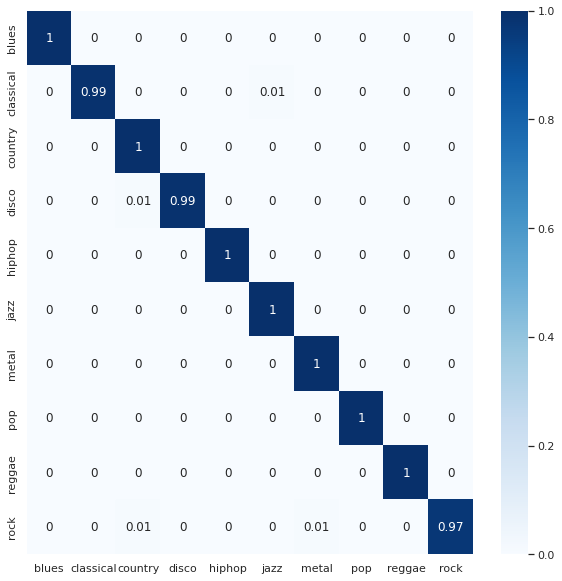

In [ ]:
plot_balanced_accuracy_heatmap(feats_y_train, y_pred_train, labels = le.classes_)

Acurácia balanceada:0.7866666666666666



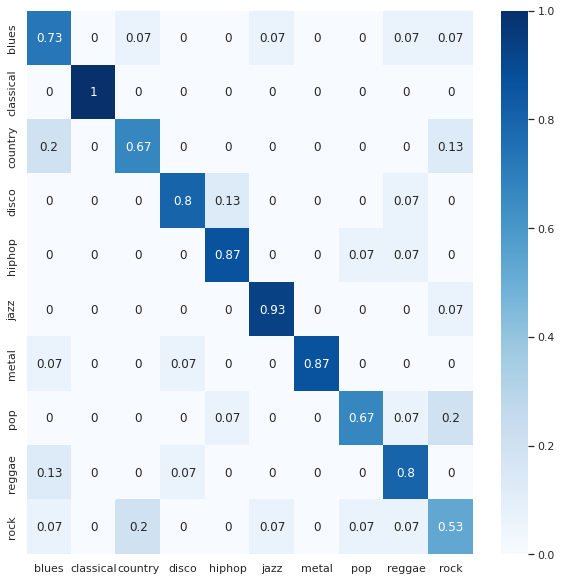

In [ ]:
plot_balanced_accuracy_heatmap(feats_y_val, y_pred_val, labels = le.classes_)

#### Random Forest com Grid Search

In [ ]:
y_pred_train, y_pred_val = train_predict_best_rf_model(feats_x_train, feats_y_train, feats_x_val)

param_grid: {'n_estimators': [25, 50, 100, 200, 300], 'max_depth': [10, 25, 50, 75, 100]}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .....max_depth=10, n_estimators=25;, score=0.921 total time=   0.3s
[CV 2/5] END .....max_depth=10, n_estimators=25;, score=0.886 total time=   0.3s
[CV 3/5] END .....max_depth=10, n_estimators=25;, score=0.886 total time=   0.3s
[CV 4/5] END .....max_depth=10, n_estimators=25;, score=0.871 total time=   0.3s
[CV 5/5] END .....max_depth=10, n_estimators=25;, score=0.914 total time=   0.3s
[CV 1/5] END .....max_depth=10, n_estimators=50;, score=0.929 total time=   0.6s
[CV 2/5] END .....max_depth=10, n_estimators=50;, score=0.900 total time=   0.6s
[CV 3/5] END .....max_depth=10, n_estimators=50;, score=0.914 total time=   0.6s
[CV 4/5] END .....max_depth=10, n_estimators=50;, score=0.921 total time=   0.6s
[CV 5/5] END .....max_depth=10, n_estimators=50;, score=0.886 total time=   0.6s
[CV 1/5] END ....max_depth=10, n_estim

KeyboardInterrupt: ignored

In [ ]:
plot_balanced_accuracy_heatmap(feats_y_val, y_pred_val, labels = le.classes_)

### VGG19

In [ ]:
vgg16 = tf.keras.applications.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)

vgg16.trainable = True


vgg16_model = tf.keras.Sequential([
  vgg16,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(10, activation='softmax')
])

vgg16_model.build()
vgg16_model.summary()

In [ ]:
vgg16_model.compile(
    loss='categorical_crossentropy', 
    optimizer=adam, 
    metrics=['accuracy']
)

In [ ]:
image_preprocessing = tf.keras.applications.vgg19.preprocess_input
train_batches, val_batches = generate_batches(image_preprocessing)

In [ ]:
vgg16_model.fit( 
            train_batches,
            validation_data = val_batches, 
            epochs = 50,
            callbacks = [early]
        )

In [ ]:
history_df = pd.DataFrame(vgg16_model.history.history)
history_df[['accuracy', 'val_accuracy']].plot()

### Inception v3

In [ ]:
inception = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    classes=1000,
    classifier_activation="softmax",
)

inception.trainable = True

inception_model = tf.keras.Sequential([
  inception,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(10, activation='softmax')
])

inception_model.build()
inception_model.summary()

In [ ]:
inception_model.compile(
    loss='categorical_crossentropy', 
    optimizer=adam, metrics=['accuracy']
)

In [ ]:
image_preprocessing = tf.keras.applications.inception_v3.preprocess_input
train_batches, val_batches = generate_batches(image_preprocessing)

In [ ]:
inception_model.fit( 
            train_batches,
            validation_data = val_batches, 
            epochs = 30,
            callbacks = [early]
        )

#### Extração de features

In [ ]:
feats_x_train, feats_y_train, feats_x_val, feats_y_val = feature_extrator(inception_model, -2)

#### SVM com Grid Search

In [ ]:
y_pred_train, y_pred_val = train_predict_best_svm_model(feats_x_train, feats_y_train, feats_x_val)

In [ ]:
plot_balanced_accuracy_heatmap(feats_y_val, y_pred_val, labels = le.classes_)

## Aplicando no conjunto de teste

In [ ]:
y_pred_test = np.argmax(resnet_model.predict(tf.keras.applications.resnet50.preprocess_input(X_test)), axis = 1)

In [ ]:
feats_y_test = np.argmax(Y_test, axis=1)

Acurácia balanceada:0.74



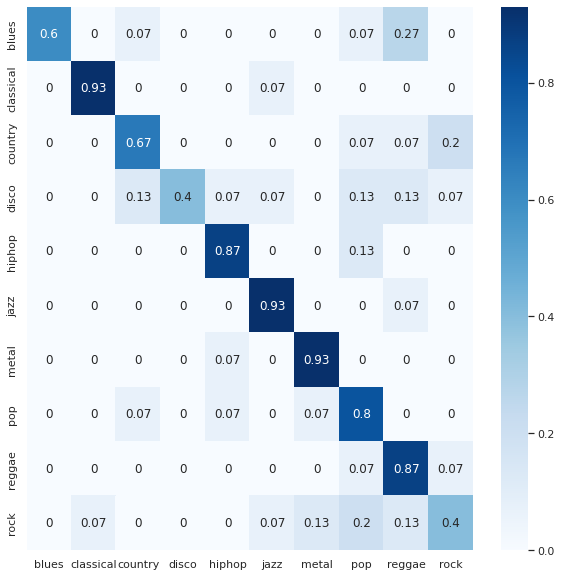

In [ ]:
plot_balanced_accuracy_heatmap(feats_y_test, y_pred_test)